In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hypernetx as hnx
import networkx as nx
import random
import seaborn as sns
import community

## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'
runDir = 'expectedReadCutoffEvaluation_v0/'
plotDir = f'{dataDir}{runDir}Plots_10kChains_600_750_3/'
outDir = f'{dataDir}{runDir}dfs_10kChains_600_750_3/'

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from chains import dictToDF
from incidenceToProjection import makeHiC_fromInc
from edgeWeightFormulations import finalBounded

 No module named 'celluloid'. If you need to use hypernetx.algorithms.contagion, please install additional packages by running the following command: pip install .['all']


In [2]:
numFiles = 10000
with open(f'{dataDir}makeHyperGraphDict/hyperEdges_3_600_750_{numFiles}_chains.pkl','rb') as f:
    hpEdges = pickle.load(f)

numEdges = np.loadtxt(f'{dataDir}makeHyperGraphDict/numEdges_3_600_750_{numFiles}_chains.txt')

In [3]:
hpKeys = [k for k in hpEdges.keys()]
hpKeys_split = [k.split("_") for k in hpEdges.keys()]
keyCard = [len(item) for item in hpKeys_split]

In [4]:
card = 7
coSimFile = pd.read_csv(f'{outDir}cosineSim_card{card}.csv',sep = "\t")
wDistFile = pd.read_csv(f'{outDir}wDist_card{card}.csv',sep = "\t")

In [5]:
agreement_status = ["Agree:Interesting" if v1 == 1 and v2 == 1 else 
                    "CoSim only" if v1 == 1 else "WDist only" if v2 == 1 
                    else "Expected" for 
                    v1, v2 in zip(coSimFile['Status'], wDistFile['Status'])]

In [6]:
print(len(agreement_status))
consensusIx = [coSimFile['Edge_ix'][ix] for ix,x in enumerate(agreement_status) if x == "Agree:Interesting"]
print(len(consensusIx))
randList = random.sample(range(coSimFile.shape[0]),len(consensusIx))

35868
1358


In [14]:
# card = 7
# coSim = pd.read_csv(f'{outDir}/cosineSim_card{card}.csv',sep = "\t")
# toKeep = list(coSim[coSim['Status'] == 1]['Edge_ix'])
# randList = random.sample(range(coSim.shape[0]),len(toKeep))

In [7]:
subsetKeys = [hpKeys[ix] for ix in consensusIx]
subsetKeyCard = [keyCard[ix] for ix in consensusIx]

In [8]:
subsetDict = {key: hpEdges[key] for key in subsetKeys}

In [9]:
subset_incDF = dictToDF(subsetDict)

In [10]:
finalBoundedScores = [finalBounded(list(subset_incDF[c])) for c in subset_incDF.columns]

In [11]:
rsubsetKeys = [hpKeys[ix] for ix in randList]
rsubsetKeyCard = [keyCard[ix] for ix in randList]
rsubsetDict = {key: hpEdges[key] for key in rsubsetKeys}
rsubset_incDF = dictToDF(rsubsetDict)

randomBoundedScores = [finalBounded(list(rsubset_incDF[c])) for c in rsubset_incDF.columns]

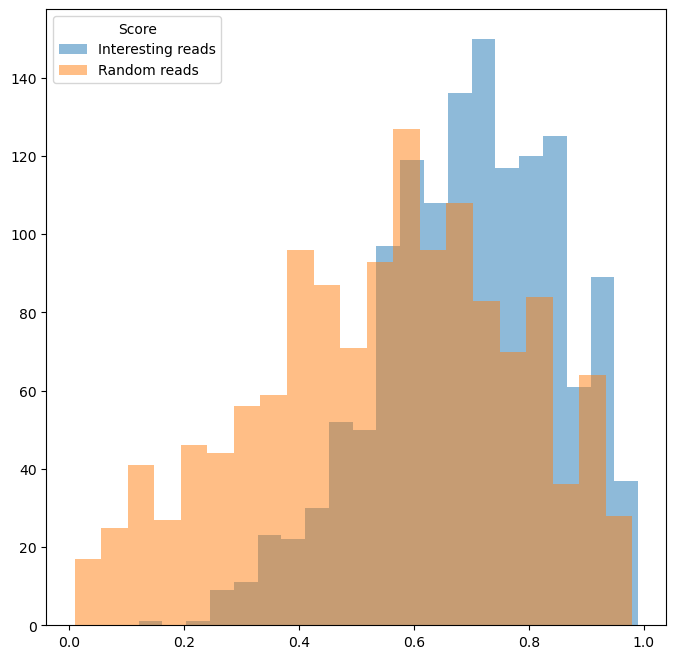

In [37]:
plt.hist(finalBoundedScores,bins = 21,alpha =0.5)
plt.hist(randomBoundedScores,bins = 21,alpha =0.5)
plt.legend(title="Score",loc="upper left",labels = ("Interesting reads","Random reads"))

In [12]:
cutoff = 0.8
interestingEdges = [i for i,x in enumerate(finalBoundedScores) if x > cutoff]
highInterestSubset_incDF = subset_incDF.iloc[:,interestingEdges]
highInterestSubset_incDF.shape

(100, 458)

In [50]:
projMat = makeHiC_fromInc(highInterestSubset_incDF)

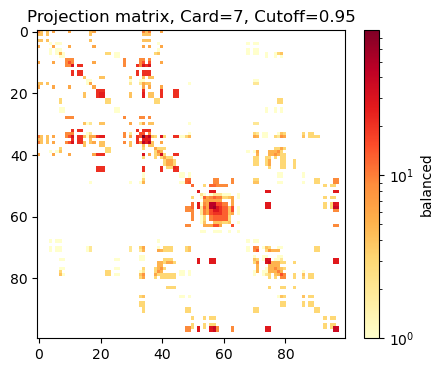

In [51]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(projMat, cmap="YlOrRd",norm = LogNorm())
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title(f"Projection matrix, Card={card}, Cutoff={cutoff}")
plt.show()

In [13]:
print(highInterestSubset_incDF.shape)
def sort_key(item):
    return int(item.split(':')[1])
binIDs = list(highInterestSubset_incDF.index)
sorted_binIDs = sorted(binIDs, key=sort_key)
highInterestSubset_incDF = highInterestSubset_incDF.reindex(index = sorted_binIDs)

(100, 458)


/gpfs/commons/home/ajoglekar/.conda/envs/noush_base/envs/hypergraph_poreC/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


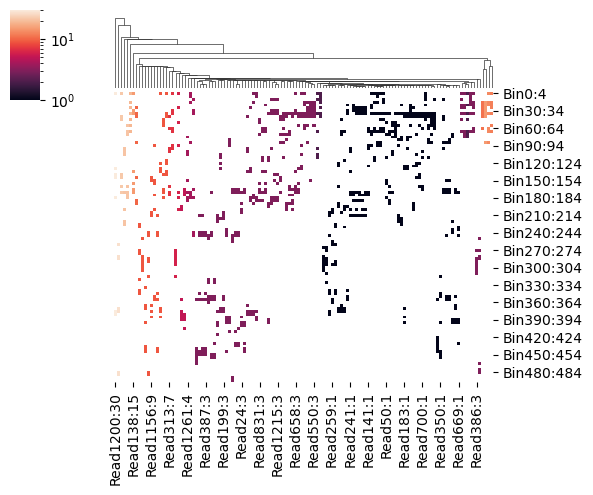

In [56]:
# plt.figure(figsize=(6, 4))
# im = plt.imshow(highInterestSubset_incDF, cmap="YlOrRd")
# plt.colorbar(im, fraction=0.046, pad=0.04);
# plt.title(f"Inc DF, Card={card}, Cutoff={cutoff}")
# plt.show()

readSupport = np.array([int(r.split(":")[1]) for r in highInterestSubset_incDF.columns])
incDFByRS = highInterestSubset_incDF.mul(readSupport.squeeze(), axis=1)

sns.clustermap(incDFByRS,figsize=(6, 5),
               row_cluster=False,
               norm = LogNorm())

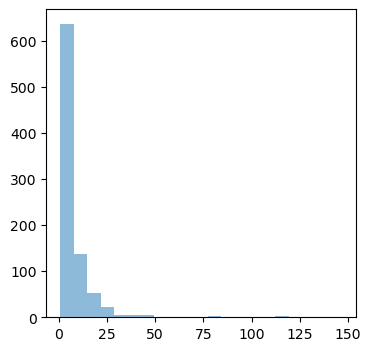

In [26]:
readSupport = [int(r.split(":")[1]) for r in highInterestSubset_incDF.columns]
plt.figure(figsize=(4,4))
plt.hist(readSupport,bins = 21,alpha =0.5)
plt.show()

In [14]:
highInterestSubset_incDF.index = ["Bin"+str((int(i.split(":")[1])+1)//5) for i in highInterestSubset_incDF.index]
HIS = hnx.Hypergraph.from_incidence_dataframe(highInterestSubset_incDF)
weights = pd.Series([finalBoundedScores[i] for i in interestingEdges], index = highInterestSubset_incDF.columns)

for e in HIS.edges:
    HIS.edges[e].weight = weights[e]

# hnx.draw(HIS)

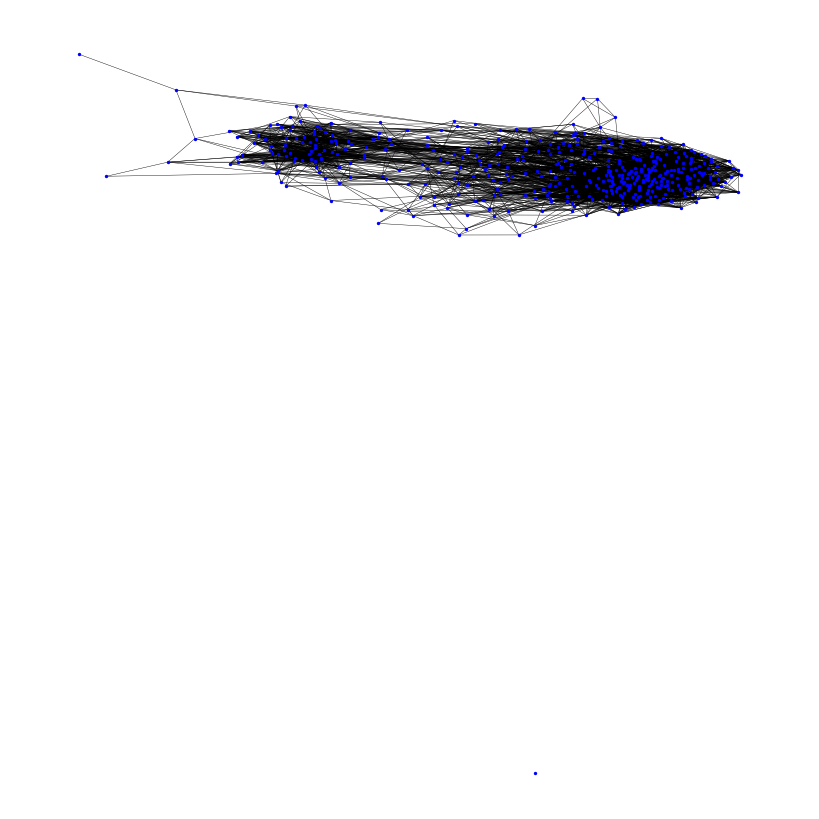

In [17]:
l = HIS.get_linegraph(s = 3)
nx.draw(l,node_size = 2, node_color = "blue",width = 0.3)

In [31]:
highInterestSubset_incDF.index = ["Bin"+str((int(i.split(":")[1])+1)//5) for i in highInterestSubset_incDF.index]
weights = pd.Series([finalBoundedScores[i] for i in interestingEdges], index = highInterestSubset_incDF.columns)
highIntAndExpr = [i for i,x in enumerate(readSupport) if x>50]
highIntAndExprSubset_incDF = highInterestSubset_incDF.iloc[:,highIntAndExpr]
highIntAndExprSubset_incDF.shape

(100, 9)

[0, 3, 9, 40, 44, 74, 75]
['Read2067:117', 'Read2640:54', 'Read2886:81', 'Read4151:117', 'Read5234:63', 'Read5936:147', 'Read6095:81', 'Read6515:64', 'Read7354:78']


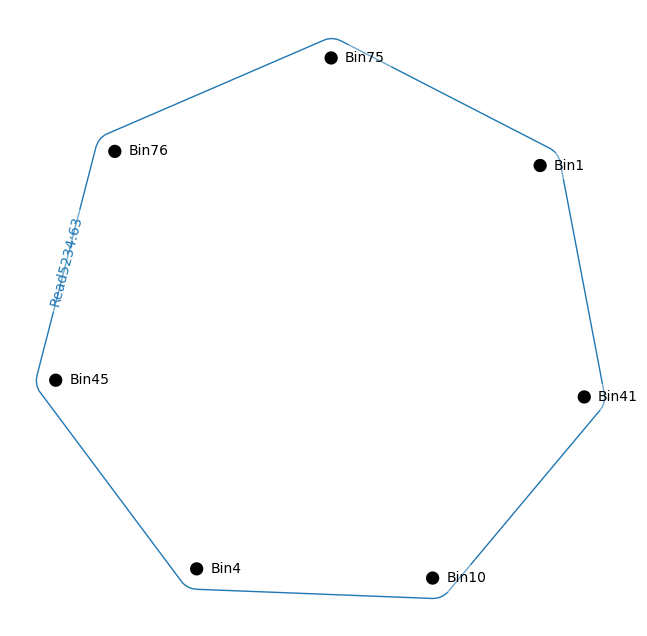

In [54]:
print([i for i,x in enumerate(list(highIntAndExprSubset_incDF['Read5234:63'])) if x == 1])
print(list(HIES.edges))

hnx.draw(HIES.restrict_to_edges(['Read5234:63']))

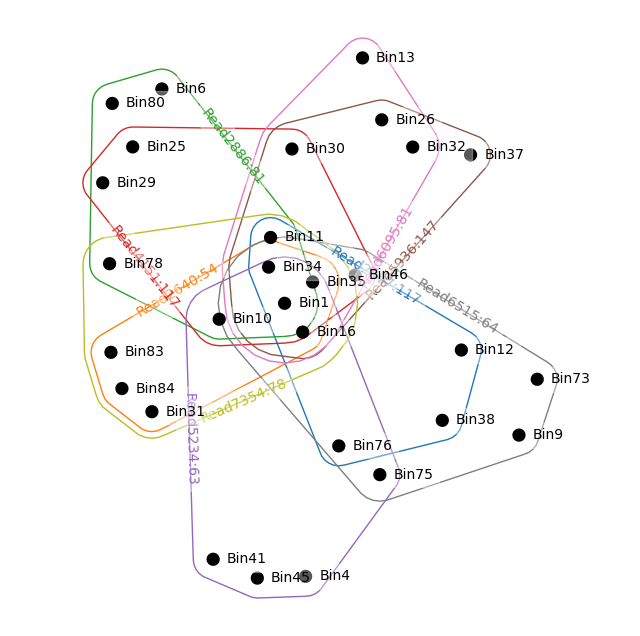

In [32]:
HIES = hnx.Hypergraph.from_incidence_dataframe(highIntAndExprSubset_incDF)

for e in HIES.edges:
    HIES.edges[e].weight = weights[e]

hnx.draw(HIES)

In [292]:
HIS.is_connected(s=3)

False

In [316]:
A, names = HIS.adjacency_matrix(s = 4, index = True)
A = A.todense()
g = HIS.get_linegraph(s = 4, edges = False)
A.shape

(100, 100)

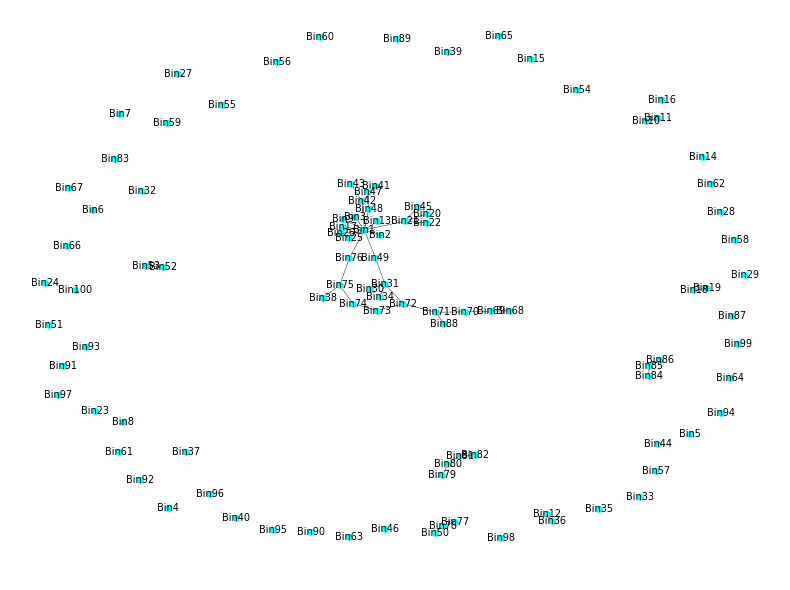

In [317]:
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw(g, with_labels = True, node_size = 15, node_color = "cyan",font_size=7, width = 0.3)
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()

/scratch/ipykernel_7421/2205544203.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis_r', max(partition1.values()) + 1)


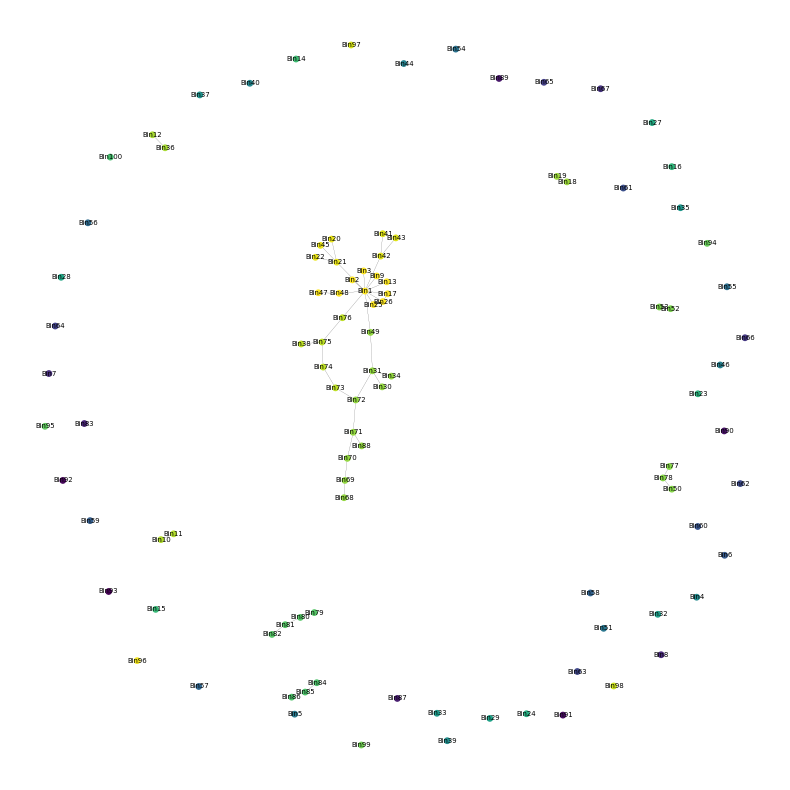

In [318]:
partition1 = community.best_partition(g)
cmap = cm.get_cmap('viridis_r', max(partition1.values()) + 1)

fig, ax = plt.subplots(figsize=(8, 8))
pos = nx.spring_layout(g)
offset = {k: (v[0], v[1] + 0.1) for k, v in pos.items()}  # Specify the desired offset
nx.draw(g, with_labels = True, node_size = 15, font_size=5, width = 0.1, cmap=cmap, node_color=list(partition1.values()))
plt.axis('off')
plt.tight_layout()

# Show the plot
plt.show()

In [305]:
graphComps = HIS.s_component_subgraphs(s = 4, edges = False,return_singletons=False, name=None)

In [306]:
nodeNames = []
for index, comp in enumerate(graphComps):
    print(index, comp.number_of_nodes())
    nodeNames.append([n for n in comp.nodes])
    print([n for n in comp.nodes])

0 32
['Bin25', 'Bin69', 'Bin13', 'Bin75', 'Bin48', 'Bin20', 'Bin45', 'Bin2', 'Bin49', 'Bin76', 'Bin30', 'Bin31', 'Bin41', 'Bin34', 'Bin38', 'Bin26', 'Bin72', 'Bin43', 'Bin21', 'Bin47', 'Bin9', 'Bin3', 'Bin1', 'Bin68', 'Bin73', 'Bin88', 'Bin74', 'Bin42', 'Bin71', 'Bin70', 'Bin22', 'Bin17']
1 2
['Bin10', 'Bin11']
2 2
['Bin12', 'Bin36']
3 2
['Bin19', 'Bin18']
4 3
['Bin50', 'Bin77', 'Bin78']
5 2
['Bin52', 'Bin53']
6 4
['Bin79', 'Bin80', 'Bin81', 'Bin82']
7 3
['Bin86', 'Bin84', 'Bin85']


In [276]:
binVec = [int(n.strip("Bin")) for n in nodeNames[0]]

In [278]:
binVec.sort()
binVec



[1, 2, 3, 9, 13, 18, 21, 26, 42, 46]